In [1]:
import biotite.sequence as biotite_seq
import biotite.sequence.align as align
substitution_matrix = align.SubstitutionMatrix.std_nucleotide_matrix()
import glob
import pandas as pd
import wandb
import itertools
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.cm import coolwarm
from matplotlib.colors import Normalize

In [2]:
api = wandb.Api()
eps = 1e-3

In [3]:
oracle_maximize = False
k = 100
AL_BATCH_SIZE = 512

sf_train_dataset = "/home/mila/n/nikita.saxena/activelearning/storage/dna/length30/sf/80_data_train.csv"
sf_test_dataset = "/home/mila/n/nikita.saxena/activelearning/storage/dna/length30/sf/80_data_test.csv"
sf_logdir = "/network/scratch/n/nikita.saxena/logs/activelearning/2023-05-06_11-38-43"
sf_run_path = "nikita0209/Aptamers-DKL/f6bh3n52"

index_train_dataset = "//home/mila/n/nikita.saxena/activelearning/storage/dna/length30/mf/data_train.csv"
index_test_dataset = "/home/mila/n/nikita.saxena/activelearning/storage/dna/length30/mf/data_test.csv"
index_logdir ="/network/scratch/n/nikita.saxena/logs/activelearning/2023-05-05_14-26-31"
index_run_path = "nikita0209/Aptamers-DKL/q8pu5t73"

linear_train_dataset = index_train_dataset
linear_test_dataset = index_test_dataset
linear_logdir = "/network/scratch/n/nikita.saxena/logs/activelearning/2023-05-06_04-35-33"
linear_run_path = "nikita0209/Aptamers-DKL/kq8kdiyf"

In [4]:

def find_pkl_file(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.pkl'):
                return os.path.join(root, file)
    return None

def get_diversity(seqs):
    # print(len(seqs))
    seqs = [biotite_seq.NucleotideSequence(seq) for seq in seqs]
    scores = []
    for pair in itertools.combinations(seqs, 2):
    # for i in range(len(seqs)):
        # for j in range(i+1, len(seqs)):
        alignment = align.align_optimal(pair[0], pair[1], substitution_matrix, local=False, max_number=1)[0]
        scores.append(align.get_sequence_identity(alignment))
    scores = torch.FloatTensor(scores)
    return torch.mean(scores)


def get_novelty(dataset_seqs, sampled_seqs):
    # print(len(dataset_seqs), len(sampled_seqs))
    sampled_seqs = [biotite_seq.NucleotideSequence(seq) for seq in sampled_seqs]
    dataset_seqs = [biotite_seq.NucleotideSequence(seq) for seq in dataset_seqs]
    min_dists = []
    for sample in sampled_seqs:
        dists = []
        sample_repeated = itertools.repeat(sample, len(dataset_seqs))
        for s_0, x_0 in zip(sample_repeated, dataset_seqs):
             alignment = align.align_optimal(s_0, x_0, substitution_matrix, local=False, max_number=1)[0]
             dists.append(align.get_sequence_identity(alignment))
        min_dists.append(min(dists))
    min_dists = torch.FloatTensor(min_dists)
    return torch.mean(min_dists)

In [5]:
def get_performance(train_dataset, test_dataset, logdir, run_path, oracle_maximize, is_mf=False, eps=1e-3):
    initial_train_dataset = pd.read_csv(train_dataset, index_col=0)
    initial_test_dataset = pd.read_csv(test_dataset, index_col=0)

    initial_train_samples = initial_train_dataset["samples"].values
    initial_test_samples = initial_test_dataset["samples"].values
    # or as lists add them together
    initial_dataset_samples = np.concatenate([initial_train_samples, initial_test_samples]).tolist()
    if is_mf==True:
        initial_dataset_samples = [sample.split(";")[0] for sample in initial_dataset_samples]
    # files_with_sampled_sequences = glob.glob(os.path.join(logdir, "data/*sampled_iter*.csv"))
    # k = 10

    pkl_file = find_pkl_file(logdir)
    culm_pkl = pd.read_pickle(pkl_file)
    culm_samples = culm_pkl['cumulative_sampled_samples']
    culm_energies = culm_pkl['cumulative_sampled_energies']
    del culm_pkl

    metric_diversity = []
    metric_novelty = []
    metric_energy = []
    metric_cost = []
    
    run = api.run(run_path)
    # mean_energy_from_wandb = run.history(keys=["mean_energy_top{}".format(k)])
    # mean_energy_from_wandb = mean_energy_from_wandb["mean_energy_top{}".format(k)].values
    post_al_cum_cost = run.history(keys=["post_al_cum_cost"])
    post_al_cum_cost = np.unique(post_al_cum_cost['post_al_cum_cost'])

    steps = np.arange(start = AL_BATCH_SIZE, stop = len(culm_samples), step = AL_BATCH_SIZE, dtype=int)
    for idx, upper_bound in enumerate(steps):
        # print(upper_bound)
        culm_samples_curr_iter = culm_samples[0:upper_bound]
        culm_sampled_energies_curr_iter = culm_energies[0:upper_bound]

        idx_topk = torch.argsort(culm_sampled_energies_curr_iter, descending=oracle_maximize)[:k].tolist()
        samples_topk = [culm_samples_curr_iter[i] for i in idx_topk]
        energies_topk = [culm_sampled_energies_curr_iter[i] for i in idx_topk]
        mean_energy_topk = torch.mean(torch.FloatTensor(energies_topk))
        # diff = abs(mean_energy_topk-mean_energy_from_wandb[idx])
        # if diff>eps:
            # print("ERROR: energy from wandb does not match for the {}th iteration".format(idx))
        metric_energy.append(mean_energy_topk.numpy())
        mean_diversity_topk = get_diversity(samples_topk)
        mean_novelty_topk = get_novelty(sampled_seqs=samples_topk, dataset_seqs=initial_dataset_samples)
        metric_diversity.append(mean_diversity_topk.numpy())
        metric_novelty.append(mean_novelty_topk.numpy())
        metric_cost.append(post_al_cum_cost[idx])

    # PLOT METRICS
    reward = np.array(metric_energy).reshape(-1,1)
    diversity = np.array(metric_diversity).reshape(-1,1)
    novelty = np.array(metric_novelty).reshape(-1,1)
    cost = np.array(metric_cost).reshape(-1,1)

    del culm_samples, culm_energies, metric_diversity, metric_novelty, metric_energy, metric_cost, initial_train_dataset, initial_test_dataset, initial_train_samples, initial_test_samples, initial_dataset_samples
    return reward, diversity, novelty, cost

In [6]:
sf_reward, sf_diversity, sf_novelty, sf_cost = get_performance(train_dataset=sf_train_dataset, test_dataset=sf_test_dataset, logdir=sf_logdir, run_path=sf_run_path, oracle_maximize=False)
index_reward, index_diversity, index_novelty, index_cost = get_performance(train_dataset=index_train_dataset, test_dataset=index_test_dataset, logdir=index_logdir, run_path=index_run_path, oracle_maximize=False, is_mf=True)
linear_reward, linear_diversity, linear_novelty, linear_cost = get_performance(train_dataset=linear_train_dataset, test_dataset=linear_test_dataset, logdir=linear_logdir, run_path=linear_run_path, oracle_maximize=False, is_mf=True)

/tmp/ipykernel_14668/1706254448.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm)


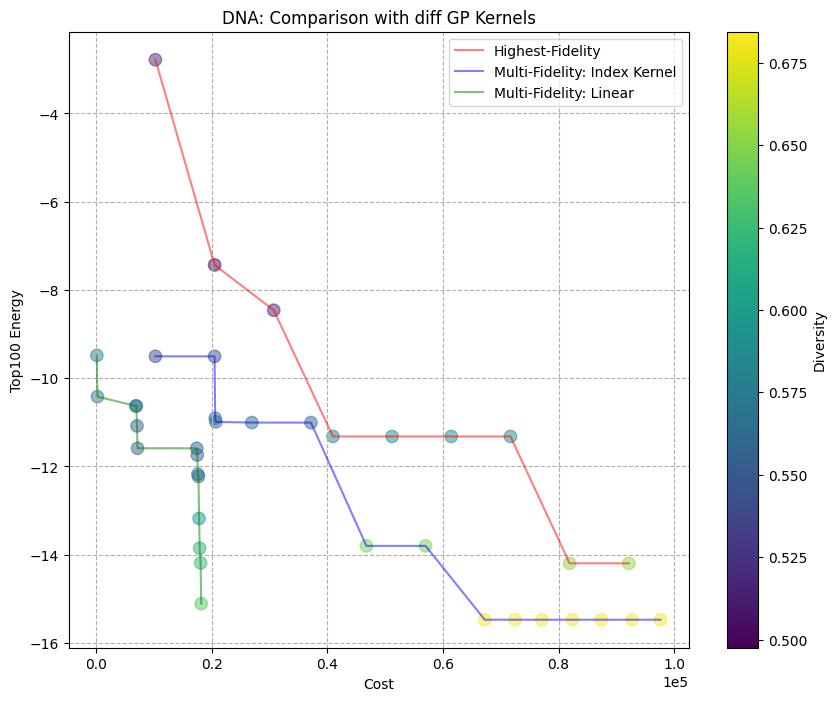

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))

sf_plot = ax.plot(sf_cost, sf_reward, label="Highest-Fidelity", color="red", linestyle="-", alpha=0.5)
index_plot = ax.plot(index_cost, index_reward, label="Multi-Fidelity: Index Kernel", color="blue", linestyle="-", alpha=0.5)
linear_plot = ax.plot(linear_cost, linear_reward, label="Multi-Fidelity: Linear", color="green", linestyle="-", alpha=0.5)

ax.set_xlabel("Cost")
ax.set_ylabel("Top{} Energy".format(k))
ax.set_title('DNA: Comparison with diff GP Kernels')
ax.grid(True, linestyle='--')
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

# Add a legend
ax.legend(loc='upper right')

vmin = np.min([np.min(sf_diversity), np.min(index_diversity), np.min(linear_diversity)])
vmax = np.max([np.max(sf_diversity), np.max(index_diversity), np.max(linear_diversity)])
# Create a single ScalarMappable object for the colorbar
div_norm = Normalize(vmin=vmin, vmax=vmax)
div_cmap = coolwarm
div_cmap = 'viridis'
sm = plt.cm.ScalarMappable(cmap=div_cmap, norm=div_norm)

sf_scatter = ax.scatter(sf_cost, sf_reward, c=sf_diversity, cmap=div_cmap, norm=div_norm, s=80, alpha=0.5)
index_scatter = ax.scatter(index_cost, index_reward, c=index_diversity, cmap=div_cmap, norm=div_norm, s=80, alpha=0.5)
linear_scatter = ax.scatter(linear_cost, linear_reward, c=linear_diversity, cmap=div_cmap, norm=div_norm, s=80, alpha=0.5)

ax.legend()
cbar = fig.colorbar(sm)
cbar.ax.set_ylabel('Sequence Identity')
plt.show()

In [9]:
print(sf_reward[-2], sf_diversity[-2], sf_novelty[-2], sf_cost[-2])

[-14.195614] [0.65343404] [0.22672042] [81920]


In [12]:
print(index_reward[-7], index_diversity[-7], index_novelty[-7], index_cost[-7])

[-15.473749] [0.6843823] [0.0995914] [67231.8]


In [13]:
print(linear_reward[-1], linear_diversity[-1], linear_novelty[-1], linear_cost[-1])

[-15.110456] [0.63523746] [0.11851613] [18164.6]
